# Semantic Image segmentation

This tutorial focuses on the task of semantic image segmentation, using a modified <a href="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/" class="external">U-Net</a>.

## What is image segmentation?

In an image classification task the network assigns a label (or class) to each input image. However, suppose you want to know the shape of that object, which pixel belongs to which object, etc. In this case you will want to assign a class to each pixel of the image. This task is known as segmentation. A segmentation model returns much more detailed information about the image. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging to name a few.

This tutorial uses the Clothing Co-Parsing (CCP) dataset is a new clothing database including elaborately annotated clothing items.(https://github.com/amirgholipour/clothing-co-parsing)


The dataset consists of 

    + 2, 098 high-resolution street fashion photos with totally 59 tags
    + Wide range of styles, accessaries, garments, and pose
    + All images are with image-level annotations
    + 1000+ images are with pixel-level annotations
    
@inproceedings{yang2014clothing,
  title={Clothing Co-Parsing by Joint Image Segmentation and Labeling},
  author={Yang, Wei and Luo, Ping and Lin, Liang}
  booktitle={Computer Vision and Pattern Recognition (CVPR), 2014 IEEE Conference on},
  year={2013},
  organization={IEEE}
}. 

In [ ]:
%pip install git+https://github.com/tensorflow/examples.git

In [ ]:
%pip install -r requirements.txt


In [ ]:
%pip install tensorflow --upgrade

In [6]:
import tensorflow as tf
from tensorflow import keras

import tensorflow_datasets as tfds

from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_addons as tfa


In [7]:
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import cv2
from scipy import io
from sklearn.model_selection import train_test_split



## Download the Clothing Co-Parsing (CCP) Dataset

The dataset is Clothing Co-Parsing (CCP) Dataset (https://github.com/bearpaw/clothing-co-parsing.git). The semantic segmentation masks are included.

In [8]:
import os 
os.system('rm -rf clone')

0

In [9]:
!git clone https://github.com/bearpaw/clothing-co-parsing.git

Cloning into 'clothing-co-parsing'...
remote: Enumerating objects: 4234, done.
remote: Total 4234 (delta 0), reused 0 (delta 0), pack-reused 4234
Receiving objects: 100% (4234/4234), 124.59 MiB | 75.76 MiB/s, done.
Resolving deltas: 100% (1100/1100), done.


In [10]:
!echo $PWD

/opt/app-root/src/Semantic-Image-Segmentation


In [11]:
!ls clothing-co-parsing/

annotations  label_list.mat  photos	show_image_anno.m
example.jpg  LICENSE	     README.md	show_pixel_anno.m


In [12]:
images = []
for i in range(1,1001):
    url = './clothing-co-parsing/photos/%04d.jpg'%(i)
    img = cv2.imread(url)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(tf.convert_to_tensor(img))

2022-03-21 04:51:46.710446: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/app-root/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-03-21 04:51:46.710510: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-21 04:51:46.710542: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyterhub-nb-skasmani-40redhat-2ecom): /proc/driver/nvidia/version does not exist
2022-03-21 04:51:46.710945: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild Ten

In [13]:
masks = []
for i in range(1,1001):
    url = './clothing-co-parsing/annotations/pixel-level/%04d.mat'%(i)
    file = io.loadmat(url)
    mask = tf.convert_to_tensor(file['groundtruth'])
    masks.append(mask)

In [14]:
len(images), len(masks)

(1000, 1000)

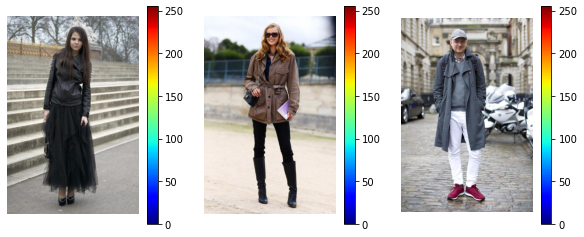

In [15]:
plt.figure(figsize=(10,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = images[i]
    plt.imshow(img, cmap='jet')
    plt.colorbar()
    plt.axis('off')
plt.show()

In [16]:
masks[0].numpy().min(), masks[0].numpy().max()

(0, 55)

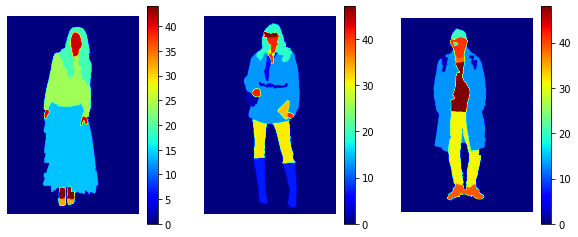

In [17]:
plt.figure(figsize=(10,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = masks[i]
    plt.imshow(img, cmap='jet')
    plt.colorbar()
    plt.axis('off')
plt.show()

### Data Preprocessing

In [18]:
def resize_image(image):
    image = tf.cast(image, tf.float32)
    # image = image/255.0
    # resize image
    image = tf.image.resize(image, (128,128))
    return image

def resize_mask(mask):
    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.image.resize(mask, (128,128))
    mask = tf.cast(mask, tf.uint8)
    return mask    

In [19]:
X = [resize_image(i) for i in images]
y = [resize_mask(m) for m in masks]
len(X), len(y)

(1000, 1000)

In [20]:
images[0].dtype, masks[0].dtype, X[0].dtype, y[0].dtype

(tf.uint8, tf.uint8, tf.float32, tf.uint8)

In [21]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap='jet') ## tensorflow 2.8
    plt.axis('off')
  plt.show()

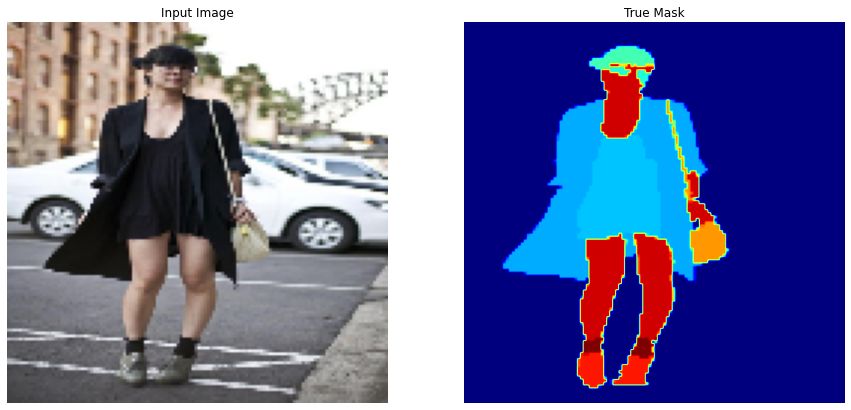

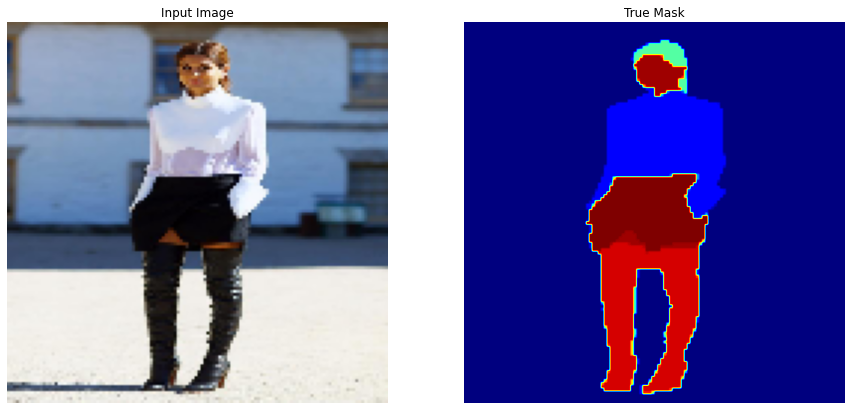

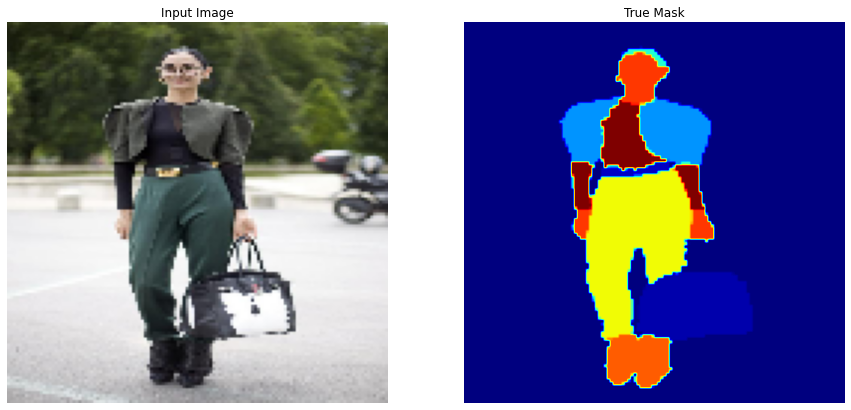

In [22]:
for i in range(10,13):
  sample_image, sample_mask = X[i], y[i]

  # tf.keras.utils.save_img(
  #       'test_sample_'+str(i)+'.jpg', sample_image
  #   )
  # tf.keras.utils.save_img(
  #       'test_sample__mask_'+str(i)+'.jpg', sample_mask
  #   )  

  display([sample_image, sample_mask])

In [23]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [24]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], pred_mask])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

The callback defined below is used to observe how the model improves while it is training.

In [25]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [26]:
type(sample_image)
i=1
tf.keras.utils.save_img(
    'sample_'+str(i)+'.jpg', sample_image
)

Note that the number of filters on the last layer is set to the number of `output_channels`. This will be one output channel per class.

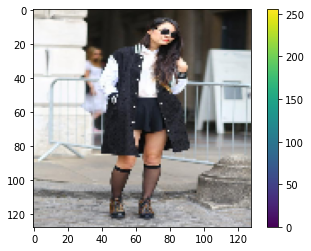

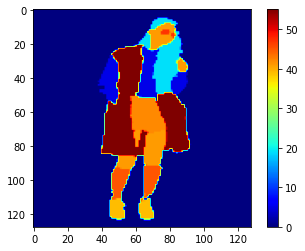

In [27]:
plt.imshow(tf.keras.utils.array_to_img(X[0]))
plt.colorbar()
plt.show()

plt.imshow(y[0], cmap='jet')
plt.colorbar()
plt.show()

### Split Data for training and validation

In [28]:
from sklearn.model_selection import train_test_split

train_X, val_X,train_y, val_y = train_test_split(X,y, 
                                                      test_size=0.2, 
                                                      random_state=0
                                                     )
train_X = tf.data.Dataset.from_tensor_slices(train_X)
val_X = tf.data.Dataset.from_tensor_slices(val_X)

train_y = tf.data.Dataset.from_tensor_slices(train_y)
val_y = tf.data.Dataset.from_tensor_slices(val_y)

train_X.element_spec, train_y.element_spec, val_X.element_spec, val_y.element_spec

(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None),
 TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))

### Data Augmentation

#### Functions for augmentation

In [29]:
def brightness(img, mask):
    img = tf.image.adjust_brightness(img, 0.1)
    return img, mask

def gamma(img, mask):
    img = tf.image.adjust_gamma(img, 0.1)
    return img, mask

def hue(img, mask):
    img = tf.image.adjust_hue(img, -0.1)
    return img, mask

def crop(img, mask):
    img = tf.image.central_crop(img, 0.7)
    img = tf.image.resize(img, (128,128))
    mask = tf.image.central_crop(mask, 0.7)
    mask = tf.image.resize(mask, (128,128))
    mask = tf.cast(mask, tf.uint8)
    return img, mask

def flip_hori(img, mask):
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

def flip_vert(img, mask):
    img = tf.image.flip_up_down(img)
    mask = tf.image.flip_up_down(mask)
    return img, mask

def rotate(img, mask):
    img = tf.image.rot90(img)
    mask = tf.image.rot90(mask)
    return img, mask

Augmentation

In [30]:
train = tf.data.Dataset.zip((train_X, train_y))
val = tf.data.Dataset.zip((val_X, val_y))

# perform augmentation on train data only

a = train.map(brightness)
b = train.map(gamma)
c = train.map(hue)
d = train.map(crop)
e = train.map(flip_hori)
f = train.map(flip_vert)
g = train.map(rotate)

train = train.concatenate(a)
train = train.concatenate(b)
train = train.concatenate(c)
train = train.concatenate(d)
train = train.concatenate(e)
train = train.concatenate(f)
train = train.concatenate(g)

In [31]:
BATCH = 64
AT = tf.data.AUTOTUNE
BUFFER = 1000

STEPS_PER_EPOCH = 800//BATCH
VALIDATION_STEPS = 200//BATCH

In [32]:
train = train.cache().shuffle(BUFFER).batch(BATCH).repeat()
train = train.prefetch(buffer_size=AT)
val = val.batch(BATCH)

## Define the model
The model being used here is a modified [U-Net](https://arxiv.org/abs/1505.04597). A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features and reduce the number of trainable parameters, you will use a pretrained model - EfficientNetV2B0 - as the encoder. For the decoder, you will use the upsample block, which is already implemented in the [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) example in the TensorFlow Examples repo. (Check out the [pix2pix: Image-to-image translation with a conditional GAN](../generative/pix2pix.ipynb) tutorial in a notebook.)


In [33]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(input_shape=[128, 128, 3], include_top=False)
print(len(base_model.layers))
# Use the activations of these layers
layer_names = [
    
    #######EfficientNetV2B0
    'block1a_project_activation',   # 64x64
    'block2b_expand_activation',    # 32x32
    'block4a_expand_activation',    # 16x16
    'block6a_expand_activation',    # 8x8
    'block6h_project_conv',         # 4x4
    
#     #######EfficientNetV2B3
# "block1b_project_activation",      # 64x64
# "block2c_expand_activation",       # 32x32
# "block4a_expand_activation",       # 16x16
# "block6a_expand_activation",       # 8x8
# "block6l_project_conv",            # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

255


In [34]:
# base_model.summary()

In [35]:
tf.keras.utils.plot_model(base_model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples.

In [36]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [37]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x =  tf.keras.layers.Concatenate()([x, skip])

  # This is the last layer of the model
  x = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')(x)  #64x64 -> 128x128

  

  return tf.keras.Model(inputs=inputs, outputs=x)

In [38]:
OUTPUT_CLASSES = 59
model = unet_model(OUTPUT_CLASSES)

### Check for Model and Data compatibility

In [39]:
a,b = next(iter(train))
a.shape



2022-03-21 04:52:02.563425: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


TensorShape([64, 128, 128, 3])

In [40]:
# y = np.concatenate([y for x, y in train], axis=0)


2022-03-21 04:52:03.412992: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


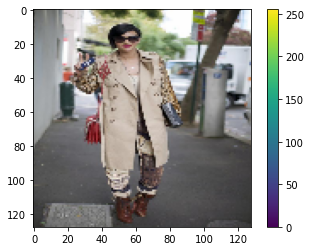

In [41]:
example = next(iter(train))
preds = model(example[0])
plt.imshow(tf.keras.utils.array_to_img(example[0][60]))

plt.colorbar()
plt.show()

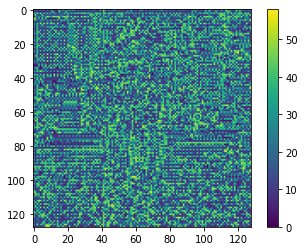

In [42]:
pred_mask = tf.argmax(preds, axis=-1)
pred_mask = tf.expand_dims(pred_mask, -1)
plt.imshow(pred_mask[0])
plt.colorbar()

## Compile the model

In [43]:
OUTPUT_CLASSES = 59
model = unet_model(OUTPUT_CLASSES)
### if you have a saved model loaded and continue training
model = tf.keras.models.load_model('./models/SemImSeg_model_EfficientNetV2B0.h5')
model.compile(
    optimizer='adam',#tfa.optimizers.Yogi(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

### Start Model Training

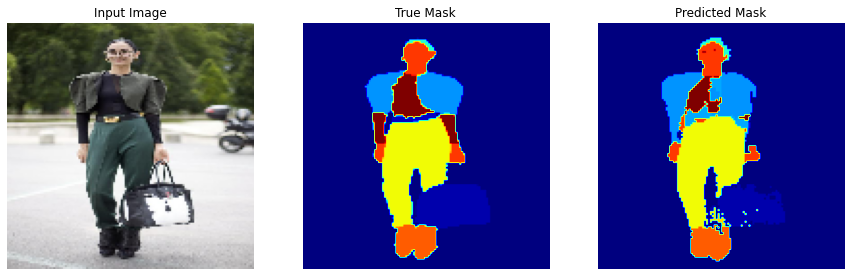


Sample Prediction after epoch 9

12/12 [==============================] - 10s 850ms/step - loss: 0.3322 - accuracy: 0.9135 - val_loss: 0.6376 - val_accuracy: 0.8505
Epoch 10/70
 2/12 [====>.........................] - ETA: 6s - loss: 0.2810 - accuracy: 0.9283

KeyboardInterrupt: 

In [44]:

EPOCHS = 70
VAL_SUBSPLITS = 5

# VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
## Saving the best model
checkpoint_filepath = './models/SemImSeg_model_EfficientNetV2B0.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    #save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
## Early Stoping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, 
)
## Train the model and save the historical information
model_history = model.fit(
    train,
    epochs=EPOCHS,
      steps_per_epoch=STEPS_PER_EPOCH,
      validation_steps=VALIDATION_STEPS,
      validation_data=val,
      callbacks=[DisplayCallback(),model_checkpoint_callback,early_stopping_callback])

#### Performance Curves

In [ ]:
history = model_history.history
acc=history['accuracy']
val_acc = history['val_accuracy']

plt.plot(acc, '-', label='Training Accuracy')
plt.plot(val_acc, '--', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Thank you for your time!

In [ ]:
# model.save('./models/SemImSeg_model_EfficientNetV2B0.h5')

In [ ]:
model = tf.keras.models.load_model('./models/SemImSeg_model_EfficientNetV2B0.h5')

## Make predictions

In [ ]:
img, mask = next(iter(val))
pred = model.predict(img)
plt.figure(figsize=(10,5))
for i in pred:
  
    print('####')
    plt.subplot(121)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet')
    plt.axis('off')
    plt.title('Prediction')
    break
plt.subplot(122)
plt.imshow(mask[0], cmap='jet')
plt.axis('off')
plt.title('Ground Truth')
plt.show()

In [ ]:
import os
os.path.getsize('./models/SemImSeg_model_EfficientNetV2B0.h5')